# Computer Vision

## IMPORTS

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm  # Progress bar for better visibility


## UNet

### Model Definitions

In [ ]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class UNet(nn.Module):
    def __init__(self, num_classes=4):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = self.conv_block(256, 512)

        # Decoder
        self.up5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec5 = self.conv_block(512, 256)

        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec6 = self.conv_block(256, 128)

        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec7 = self.conv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2)
        )
    
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)

        c2 = self.enc2(p1)
        p2 = self.pool2(c2)

        c3 = self.enc3(p2)
        p3 = self.pool3(c3)

        c4 = self.enc4(p3)

        # Decoder
        u5 = self.up5(c4)
        u5 = torch.cat([u5, c3], dim=1)
        c5 = self.dec5(u5)

        u6 = self.up6(c5)
        u6 = torch.cat([u6, c2], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c1], dim=1)
        c7 = self.dec7(u7)

        outputs = self.final_conv(c7)

        return outputs

: 

In [3]:
device = 'cpu'

model = UNet().to(device)
model.load_state_dict(torch.load('Data/Output/Models/Better_Final_Outline_unet_model_epoch_90.pth', map_location=device))

model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### Visualise Result

Selected image: /home/s2677266/CVis/Data/Output/Augmented/color/aug_2968_Abyssinian_106.jpg
Selected lable: /home/s2677266/CVis/Data/Output/Augmented/label/aug_2968_Abyssinian_106.png
torch.Size([1, 4, 256, 256])
Unique values in label image: [  0  38 255]
Unique values in predicted mask (before mapping): [0 1 2 3]
Unique values in predicted mask (after mapping): [  0  38  75 255]


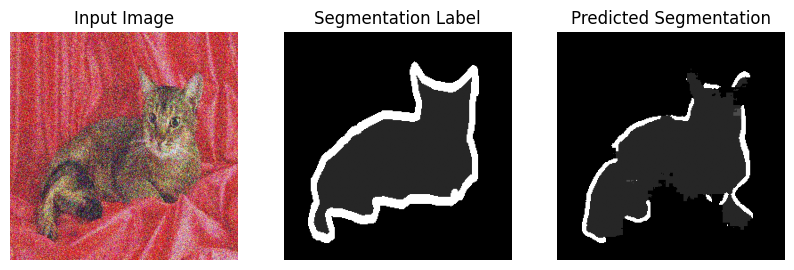

In [19]:
folder_path = "/home/s2677266/CVis/Data/Output/Augmented/color/"  # Directory containing images
label_folder_path = "/home/s2677266/CVis/Data/Output/Augmented/label/"
# Get a list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select an image
if image_files:
    img_path = os.path.join(folder_path, random.choice(image_files))
    label_path = os.path.join(label_folder_path, img_path.split('/')[-1].replace(".jpg", ".png"))
    print(f"Selected image: {img_path}")
    print(f"Selected lable: {label_path}")
    # img_path = "/home/s2677266/CVis/Data/Output/Augmented/color/aug_British_Shorthair_174.jpg"
    # label_path = "/home/s2677266/CVis/Data/Output/Augmented/label/aug_British_Shorthair_174.png"
else:
    print("No image files found in the folder.")
    
# Define transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match training input
    transforms.ToTensor()
])

# Load and preprocess the image
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

labelImage = Image.open(label_path).convert("L")
labelImage = labelImage.resize((256, 256), Image.NEAREST)
labelImage = np.array(labelImage)


# Get the model's prediction
with torch.no_grad():
    output = model(input_tensor)  # Output shape: (1, num_classes, H, W)

print(output.shape)
# Convert output to a segmentation mask
output_tensor = F.softmax(output, dim=1)
pred_mask = torch.argmax(output_tensor, dim=1).squeeze().cpu().numpy()  # Get class with highest probability
pred_mask
# Display input and output side by side

# Define the mapping from output classes to label pixel values
output_to_label_map = {
    0: 0,
    1: 38,
    2: 75,
    3: 255
}

# Convert the predicted mask to the corresponding pixel values
pred_mask_mapped = np.vectorize(output_to_label_map.get)(pred_mask)

# Display input, label, and output side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

print("Unique values in label image:", np.unique(labelImage))
print("Unique values in predicted mask (before mapping):", np.unique(pred_mask))
print("Unique values in predicted mask (after mapping):", np.unique(pred_mask_mapped))

ax[0].imshow(image)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(labelImage, cmap="gray")  # Display label image
ax[1].set_title("Segmentation Label")
ax[1].axis("off")

ax[2].imshow(pred_mask_mapped, cmap="gray")  # Display mapped prediction
ax[2].set_title("Predicted Segmentation")
ax[2].axis("off")

plt.show()



### IOU Score Calculation

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match model input size
    transforms.ToTensor(),
])

def load_image_and_label(image_path, label_path):
    """Load an image and its corresponding label, apply necessary transformations."""
    image = Image.open(image_path).convert('RGB')
    label = Image.open(label_path).convert('L')  # Load label in grayscale
    label = label.resize((256, 256), Image.NEAREST)

    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    label_array = np.array(label)  # Convert label to numpy array

    # Replace pixels with value 255 with 0
    label_array[label_array == 255] = 0

    return input_tensor, label_array

def compute_iou(pred, target, num_classes=4):
    """
    Compute the Intersection over Union (IoU) score for multi-class segmentation.
    
    :param pred: Predicted segmentation map (H, W), with class indices.
    :param target: Ground truth segmentation map (H, W), with class indices.
    :param num_classes: Number of classes in segmentation.
    :return: IoU scores per class and mean IoU.
    """
    iou_per_class = []
    
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        
        intersection = torch.logical_and(pred_inds, target_inds).sum().item()
        union = torch.logical_or(pred_inds, target_inds).sum().item()

        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore classes not present in the image
        else:
            iou_per_class.append(intersection / union)

    mean_iou = np.nanmean(iou_per_class)  # Compute mean IoU ignoring NaNs
    return iou_per_class, mean_iou

# Define file paths
image_dir = "/home/s2677266/CVis/Data/Output/Augmented/color/"
label_dir = "/home/s2677266/CVis/Data/Output/Augmented/label/"

# Get list of all images
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# Mapping between class indices and pixel values
class_to_pixel = {0: 0, 1: 38, 2: 75, 3: 255}
pixel_to_class = {v: k for k, v in class_to_pixel.items()}

# Store IoU results
all_ious = []

# Loop through all images
for image_file in tqdm(image_files, desc="Processing images"):
    # Construct full paths
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace(".jpg", ".png"))

    # Load image and label
    input_tensor, label_image = load_image_and_label(image_path, label_path)

    # Run inference
    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Apply softmax and get predicted class indices
    output_tensor = F.softmax(output_tensor, dim=1)
    predicted_classes = torch.argmax(output_tensor, dim=1).squeeze(0).cpu()  # (H, W)

    # Convert predicted class indices to pixel values
    output_pixel_values = torch.zeros_like(predicted_classes, dtype=torch.uint8)
    for class_idx, pixel_value in class_to_pixel.items():
        output_pixel_values[predicted_classes == class_idx] = pixel_value

    # Convert label image to class indices
    label_tensor = torch.tensor(label_image, dtype=torch.uint8)
    label_class_map = torch.zeros_like(label_tensor)

    for pixel_value, class_idx in pixel_to_class.items():
        label_class_map[label_tensor == pixel_value] = class_idx

    # Compute IoU
    _, mean_iou = compute_iou(output_pixel_values, label_class_map)
    all_ious.append(mean_iou)

# Compute overall mean IoU
overall_mean_iou = np.nanmean(all_ious)

print(f"Overall Mean IoU: {overall_mean_iou:.4f}")

## Autoencoder

### Model Definitions

#### Encoder Part of the Autoencoder

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 500 -> 250
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 250 -> 125
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 250 -> 125
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # Add another layer for a richer encoding
        nn.LeakyReLU(0.2),
    )

        # Decoder
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 128 -> 256
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Keep size (64, 256, 256)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # Final output (3, 256, 256)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

#### Segmentation Decoder

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual  # Skip connection
        return self.relu(x)

# Enhanced Segmentation Decoder
class SegmentationDecoder(nn.Module):
    def __init__(self, encoder):
        super(SegmentationDecoder, self).__init__()
        
        # Partially freeze encoder (freeze first few layers, fine-tune deeper ones)
        # for param in list(encoder.parameters())[:4]:  # Adjust layers to freeze
        #     param.requires_grad = False
        for param in encoder.parameters():
            param.requires_grad = True
        
        self.encoder = encoder

        # Decoder with residual blocks and skip connections
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            ResidualBlock(128, 128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            ResidualBlock(64, 64),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 4, kernel_size=1)  # Output logits
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Load Models

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
choose_autoencoder_epoch = 17
choose_segmentation_decoder_epoch = 65

autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load(f'Data/Output/Models/updated_complex_working_autoencoder_epoch_{choose_autoencoder_epoch}.pth', map_location=device))

# Load segmentation model weights
# segmentation_model = SegmentationDecoder(autoencoder.encoder).to(device)
# segmentation_model.load_state_dict(torch.load(f'Data/Output/Models/Better_Final_Segmentation_Model_epoch_{choose_segmentation_decoder_epoch}.pth', map_location=device))

# autoencoder.eval()
# segmentation_model.eval()


<All keys matched successfully>

### Visualisations

#### Visualise Encoder part of Autoencoder Result

Selected image: /home/s2677266/CVis/Data/Output/Augmented/color/aug_4836_Sphynx_204.jpg


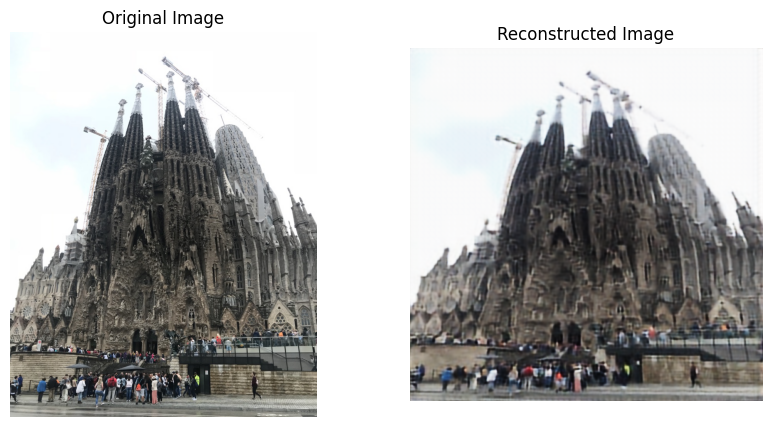

In [48]:
folder_path = "/home/s2677266/CVis/Data/Output/Augmented/color/"  # Directory containing images

# Get a list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select an image
if image_files:
    img_path = os.path.join(folder_path, random.choice(image_files))
    print(f"Selected image: {img_path}")
else:
    print("No image files found in the folder.")

# Define the same transformations used in training
transform = transforms.Compose([
    transforms.Resize((500, 500)),  # Resize to match model input size
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # If model was trained with normalization
])

# Load the image and apply transformations
image = Image.open(img_path).convert('RGB')  # Open image
image = Image.open('/home/s2677266/CVis/5D59FF09-F5CA-4E56-98E9-1E07F6E7CC2E_1_105_c.jpeg').convert('RGB')  # Open image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension: (1, C, H, W)

# Move the tensor to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

# Ensure the model is in evaluation mode
autoencoder.eval()

# Run inference (disable gradient calculations)
with torch.no_grad():
    output_tensor = autoencoder(input_tensor)

# Remove batch dimension and move to CPU
output_tensor = output_tensor.squeeze(0).cpu()

# Convert tensor back to an image
output_image = output_tensor.permute(1, 2, 0)  # Change from (C, H, W) -> (H, W, C)
# output_image = output_image * 0.5 + 0.5  # Undo normalization (if used)

# Clip values to [0,1] to avoid out-of-range issues
output_image = torch.clamp(output_image, 0, 1)

# Display the original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(output_image.numpy())  # Convert tensor to NumPy array
ax[1].set_title("Reconstructed Image")
ax[1].axis("off")

plt.show()

#### Visualise Segmentation Decoder

Selected Image: Data/Output/Augmented/color/aug_Maine_Coon_107.jpg
Corresponding Label: Data/Output/Augmented/label/aug_Maine_Coon_107.png
[0 1 2]


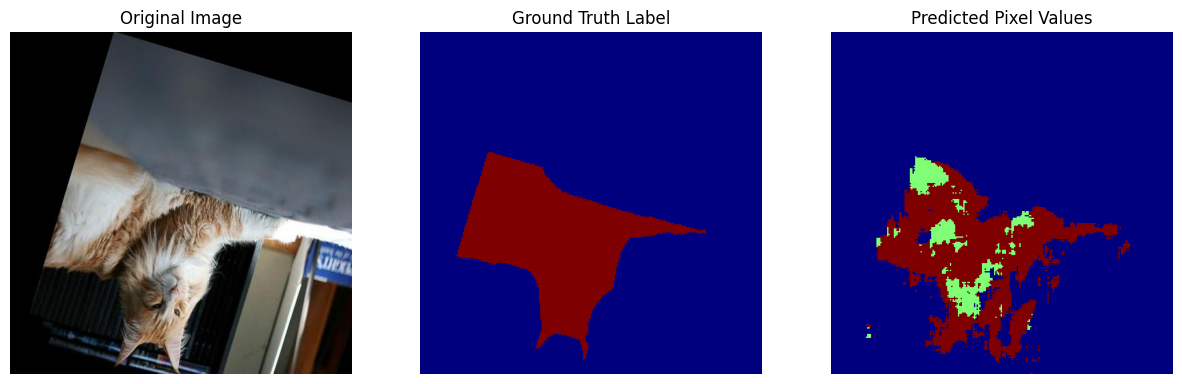

Unique values in label image: [ 0 38]
Unique values in predicted image: [ 0 38 75]


In [87]:
image_dir = "Data/Output/Augmented/color/"
label_dir = "Data/Output/Augmented/label/"

# Get list of all images
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# Randomly select an image
random_image = random.choice(image_files)

# Construct full paths
image_path = os.path.join(image_dir, random_image)
label_path = os.path.join(label_dir, random_image.replace(".jpg", ".png"))

# image_path = "Data/Output/Augmented/color/aug_american_bulldog_146.jpg"
# label_path = "Data/Output/Augmented/label/aug_american_bulldog_146.png"

# image_path = "Data/Output/Resized/color/Birman_159.jpg"
# label_path = "Data/Output/Resized/label/Birman_159.png"

print("Selected Image:", image_path)
print("Corresponding Label:", label_path)

# Define the same transformations used in training
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match model input size
    transforms.ToTensor(),
])

# Load the image and apply transformations
image = Image.open(image_path).convert('RGB')  # Open image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension: (1, C, H, W)

# Load the label image (without transformations, to keep it in its original form)
label = Image.open(label_path).convert('L')  # Load label image in grayscale (L)
label = label.resize((256, 256), Image.NEAREST)

# Move the tensor to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

# Ensure the model is in evaluation mode

# Run inference (disable gradient calculations)
with torch.no_grad():
    output_tensor = segmentation_model(input_tensor)

# Apply softmax to convert logits to probabilities
output_tensor = F.softmax(output_tensor, dim=1)  # Apply softmax along the class dimension

# Use argmax to get the most probable class for each pixel (along the class dimension)
predicted_classes = torch.argmax(output_tensor, dim=1)  # Shape: (1, H, W)
print(np.unique(predicted_classes))
# Remove batch dimension and move to CPU
predicted_classes = predicted_classes.squeeze(0).cpu()  # Shape: (H, W)

# Map class indices back to pixel values
class_to_pixel = {0: 0, 1: 38, 2: 75, 3:255}
output_pixel_values = torch.zeros_like(predicted_classes, dtype=torch.uint8)

# Reverse the class to pixel mapping
for class_idx, pixel_value in class_to_pixel.items():
    output_pixel_values[predicted_classes == class_idx] = pixel_value

# Convert tensors to NumPy arrays for visualization
output_image = output_pixel_values.numpy()
label_image = np.array(label)

# Display the original image, label image, and predicted pixel values
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(label_image, cmap="jet")  # Use a colormap for label visualization
ax[1].set_title("Ground Truth Label")
ax[1].axis("off")

ax[2].imshow(output_image, cmap="jet")  # Use a colormap for predicted classes
ax[2].set_title("Predicted Pixel Values")
ax[2].axis("off")

plt.show()

# Print unique values in the label and predicted images""
print("Unique values in label image:", np.unique(label_image))
print("Unique values in predicted image:", np.unique(output_image))

### IOU Score Calculation

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match model input size
    transforms.ToTensor(),
])

def load_image_and_label(image_path, label_path):
    """Load an image and its corresponding label, apply necessary transformations."""
    image = Image.open(image_path).convert('RGB')
    label = Image.open(label_path).convert('L')  # Load label in grayscale
    label = label.resize((256, 256), Image.NEAREST)

    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    label_array = np.array(label)  # Convert label to numpy array

    # Replace pixels with value 255 with 0
    label_array[label_array == 255] = 0

    return input_tensor, label_array


def compute_iou(pred, target, num_classes=3):
    """
    Compute the Intersection over Union (IoU) score for multi-class segmentation.
    
    :param pred: Predicted segmentation map (H, W), with class indices.
    :param target: Ground truth segmentation map (H, W), with class indices.
    :param num_classes: Number of classes in segmentation.
    :return: IoU scores per class and mean IoU.
    """
    iou_per_class = []
    
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        
        intersection = torch.logical_and(pred_inds, target_inds).sum().item()
        union = torch.logical_or(pred_inds, target_inds).sum().item()

        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore classes not present in the image
        else:
            iou_per_class.append(intersection / union)

    mean_iou = np.nanmean(iou_per_class)  # Compute mean IoU ignoring NaNs
    return iou_per_class, mean_iou

# Define file paths
image_dir = "Data/Input/Test/color/"
label_dir = "Data/Input/Test/label/"

# Get list of all images
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# Mapping between class indices and pixel values
class_to_pixel = {0: 0, 1: 38, 2: 75, 3: 255}
pixel_to_class = {v: k for k, v in class_to_pixel.items()}

# Store IoU results
all_ious = []

# Set model to evaluation mode
segmentation_model.eval()

# Loop through all images
for image_file in tqdm(image_files, desc="Processing images"):
    # Construct full paths
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace(".jpg", ".png"))

    # Load image and label
    input_tensor, label_image = load_image_and_label(image_path, label_path)

    # Run inference
    with torch.no_grad():
        output_tensor = segmentation_model(input_tensor)

    # Apply softmax and get predicted class indices
    output_tensor = F.softmax(output_tensor, dim=1)
    predicted_classes = torch.argmax(output_tensor, dim=1).squeeze(0).cpu()  # (H, W)

    # Convert predicted class indices to pixel values
    output_pixel_values = torch.zeros_like(predicted_classes, dtype=torch.uint8)
    for class_idx, pixel_value in class_to_pixel.items():
        output_pixel_values[predicted_classes == class_idx] = pixel_value

    # Convert label image to class indices
    label_tensor = torch.tensor(label_image, dtype=torch.uint8)
    label_class_map = torch.zeros_like(label_tensor)

    for pixel_value, class_idx in pixel_to_class.items():
        label_class_map[label_tensor == pixel_value] = class_idx

    # Compute IoU
    _, mean_iou = compute_iou(output_pixel_values, label_class_map)
    all_ious.append(mean_iou)

# Compute overall mean IoU
overall_mean_iou = np.nanmean(all_ious)

print(f"Overall Mean IoU: {overall_mean_iou:.4f}")


Processing images:  12%|█▏        | 437/3710 [17:21<2:10:01,  2.38s/it]


KeyboardInterrupt: 

## Clip

### Model Definition

In [ ]:
class Clip_Decoder(nn.Module):
    def __init__(self, clip_feature_dim=512, num_classes=4):
        super(Clip_Decoder, self).__init__()

        # Project CLIP features
        self.clip_fc = nn.Linear(clip_feature_dim, 128)  

        # CNN Feature Extractor
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128 + 128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True),  # Ensure fixed output size
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=1, padding=1),
        )


    def forward(self, image, clip_features):
        cnn_features = self.encoder(image)
        clip_features = self.clip_fc(clip_features).view(clip_features.shape[0], 128, 1, 1)
        clip_features = clip_features.expand(-1, -1, cnn_features.shape[2], cnn_features.shape[3])

        fusion = torch.cat([cnn_features, clip_features], dim=1)
        segmentation_output = self.decoder(fusion)
        return segmentation_output

### Load Model

In [89]:
clip_decoder_epoch = 80

clip_segmentation_model = Clip_Decoder().to('cpu')
clip_segmentation_model.load_state_dict(torch.load(f'Data/Output/Models/final_clip_segmentation_model_epoch_{clip_decoder_epoch}.pth', map_location='cpu'))
clip_segmentation_model.to('cpu')
clip_segmentation_model.eval()

Clip_Decoder(
  (clip_fc): Linear(in_features=512, out_features=128, bias=True)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(size=(256, 256), mode='bilinear')
    (3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [93]:
device = 'cpu'
clip_feature_path = '/home/s2677266/CVis/Data/Output/Models/clipTrainFeatures/aug_0_aug_Russian_Blue_146.pt'
img_path = '/home/s2677266/CVis/Data/Output/Augmented/color/aug_0_aug_Russian_Blue_146.jpg'

clip_features_dir = "/home/s2677266/CVis/Data/Output/Models/clipTrainFeatures/"
images_dir = "/home/s2677266/CVis/Data/Output/Augmented/color/"

Output shape: torch.Size([1, 3, 256, 256])


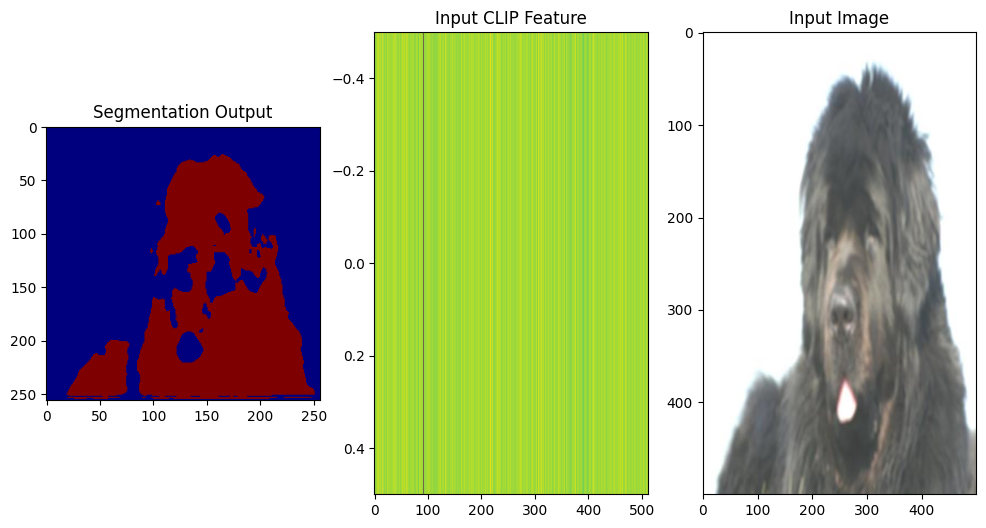

In [102]:
# Ensure model is on the correct device
clip_feature_files = [f for f in os.listdir(clip_features_dir) if f.endswith('.pt')]

# Randomly select one
random_clip_feature = random.choice(clip_feature_files)
clip_feature_path = os.path.join(clip_features_dir, random_clip_feature)

# Get corresponding image file (assuming consistent naming)
image_filename = random_clip_feature.replace(".pt", ".jpg")
img_path = os.path.join(images_dir, image_filename)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP feature
clip_feature = torch.load(clip_feature_path).to(device)

# Load and preprocess the image
imagePic = Image.open(img_path).convert("RGB")
image = transforms.ToTensor()(imagePic).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Ensure CLIP feature is shaped correctly (batch_size, clip_feature_dim)
clip_feature = clip_feature.unsqueeze(0)  # Shape: (1, 512)

# Perform inference with no gradients
with torch.no_grad():
    model_output = clip_segmentation_model(image, clip_feature)  # Output shape: (1, num_classes, H, W)

print(f"Output shape: {model_output.shape}")

# Process the output segmentation mask
segmentation_mask = model_output.squeeze(0)  # Shape: (num_classes, H, W)
segmentation_mask = torch.argmax(segmentation_mask, dim=0).cpu().numpy()  # Convert to numpy

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Show segmentation mask
axes[0].imshow(segmentation_mask, cmap='jet')
axes[0].set_title("Segmentation Output")

# Show input CLIP feature vector as a heatmap
axes[1].imshow(clip_feature.squeeze(0).cpu().numpy().reshape(1, -1), aspect="auto", cmap='viridis')
axes[1].set_title("Input CLIP Feature")

axes[2].imshow(imagePic, aspect="auto", cmap='viridis')
axes[2].set_title("Input Image")

plt.show()


### IOU Score Calculation